In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from keras.models import Sequential
from keras.layers import *
from keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

sns.set_theme(rc={'figure.figsize':(16,8)})

def plot_confusion_matrix(Y_test, predicted):
    predicted = tf.squeeze(predicted)
    predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
    actual = np.array(Y_test)
    conf_mat = confusion_matrix(actual, predicted)
    displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    displ.plot()


def my_read_data():
    # Reads already cleaned and imputed data from .csv

    file_path_train = Path('adults_data','adults_imputed_train_data.csv')
    file_path_test = Path('adults_data','adults_imputed_test_data.csv')

    df_train = pd.read_csv(file_path_train)
    df_test = pd.read_csv(file_path_test)

    X_train = df_train.iloc[:,:-1]
    X_test = df_test.iloc[:,:-1]
    X_train = pd.get_dummies(X_train, dtype=float)
    X_test = pd.get_dummies(X_test, dtype=float)
    
    Y_train = df_train.iloc[:,-1]
    Y_test = df_test.iloc[:,-1]

    Y_train = Y_train.replace("<=50K", 0)
    Y_train = Y_train.replace(">50K", 1)
    Y_test = Y_test.replace("<=50K", 0)
    Y_test = Y_test.replace(">50K", 1)

    return X_train, X_test, Y_train, Y_test


def balance_data(X_train, Y_train, type="ros"):

    if type == "ros":
        ros = RandomOverSampler(random_state=5)
        X_train, Y_train = ros.fit_resample(X_train, Y_train)
    elif type == "smote":
        smote = SMOTE(random_state=5, k_neighbors=5)
        X_train, Y_train = smote.fit_resample(X_train, Y_train)
    else:
        print("Balancing type not found")

    return X_train, Y_train

* scaling
* train test split
* oversampling

In [15]:
def classification_rnn(epochs=100, batch_size=50, balance_type=None):

    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    # Build
    model = Sequential()
    model.add(Dense(128, "relu", input_shape=(67,)))
    model.add(Dense(67, "relu"))
    model.add(Dense(1, 'sigmoid'))

    # Compile 
    model.compile(loss="binary_crossentropy", metrics=[tf.keras.metrics.Recall()], optimizer=Adam(learning_rate=0.0005))
    model.summary()

    # Fit & Predict
    model_fit = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)    
    predictions_rnn = model.predict(X_test)

    # tresholding
    predictions_rnn = np.where(predictions_rnn >= 0.5, 1, 0)

    # Get accuracy
    #train_accuracy = model_fit.history['accuracy']
    #val_accuracy = model_fit.history['val_accuracy']


    # Plot accuracy
    #epochs = range(1, len(train_accuracy) + 1)
    #plt.ylim(0,1)
    #plt.plot(epochs, train_accuracy, label="Training set")
    #plt.plot(epochs, val_accuracy, label="Validation set")
    # plt.title('Training and Validation Accuracy')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()

    print("Accuracy: ", accuracy_score(Y_test, predictions_rnn))
    print("F1 Score: ", f1_score(Y_test, predictions_rnn))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_rnn))

    cm = ConfusionMatrixDisplay.from_predictions(Y_test, predictions_rnn) 
    cm.ax_.set_title("Confusion matrix for Neural Network Classification")
    plt.show()

In [19]:
def classification_lr(balance_type=None):
    
    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_lr = LogisticRegression().fit(X_train, Y_train)
    predictions_lr = model_lr.predict(X_test)
    
    
    print("Accuracy: ", accuracy_score(Y_test, predictions_lr))
    print("F1 Score: ", f1_score(Y_test, predictions_lr))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_lr))

    cm = ConfusionMatrixDisplay.from_estimator(model_lr, X_test, Y_test) 
    cm.ax_.set_title("Confusion matrix for Logistic Regression Classification")
    plt.show()

In [20]:
def classification_xgb(balance_type=None, grid=False):

    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_xgb = XGBClassifier()

    if grid:

        param_grid = {'gamma': [0,0.1,0.2,1.6],
              'learning_rate': [0.01, 0.03, 0.1, 0.2],
              'max_depth': [7,12,15],
              'n_estimators': [35,50,80,115],
              'reg_alpha': [0,0.1,0.2,1.5],
              'reg_lambda': [0,0.05,0.1,0.3]}
        
        # Define & fit grid search
        grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train, Y_train)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1 score:", grid_search.best_score_)

        # Create the best model
        model_xgb = XGBClassifier(gamma=grid_search.best_params_['gamma'], 
                                  learning_rate=grid_search.best_params_['learning_rate'],
                                  n_estimators=grid_search.best_params_['n_estimators'],
                                  reg_alpha=grid_search.best_params_['reg_alpha'],
                                  reg_lambda=grid_search.best_params_['reg_lambda'])

    # fit & predict
    model_xgb.fit(X_train, Y_train)
    predictions_xgb = model_xgb.predict(X_test)


    print("Accuracy:", accuracy_score(Y_test, predictions_xgb))
    print("F1 Score: ", f1_score(Y_test, predictions_xgb))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_xgb))

    cm_im = ConfusionMatrixDisplay.from_estimator(model_xgb, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for XGBoost Classification")
    plt.show()

In [21]:
def classification_knn(balance_type=None, grid=False):

    X_train, X_test, Y_train, Y_test = my_read_data()

    if balance_type != None: 
        X_train, Y_train = balance_data(X_train, Y_train, type=balance_type)

    model_knn = KNeighborsClassifier()


    if grid:
        
        param_grid = {'n_neighbors': np.arange(1, 11),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2]}
        
        # Define & fit grid search
        grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='f1')
        grid_search.fit(X_train, Y_train)

        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best F1 score:", grid_search.best_score_)

        # Define best model
        model_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'],
                                    weights=grid_search.best_params_['weights'],
                                    algorithm=grid_search.best_params_['algorithm'],
                                    p=grid_search.best_params_['p'])

    # fit & predict
    model_knn.fit(X_train, Y_train)
    predictions_knn = model_knn.predict(X_test)


    print("Accuracy:", accuracy_score(Y_test, predictions_knn))
    print("F1 Score: ", f1_score(Y_test, predictions_knn))
    print("\nClassification Report:")
    print(classification_report(Y_test, predictions_knn))

    cm_im = ConfusionMatrixDisplay.from_estimator(model_knn, X_test, Y_test) 
    cm_im.ax_.set_title("Confusion matrix for KNN Classification")
    plt.show()

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best F1 score: 0.8923095016358025
Accuracy: 0.9476141867384836
F1 Score:  0.8945527673340911

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     34621
           1       0.89      0.90      0.89     11422

    accuracy                           0.95     46043
   macro avg       0.93      0.93      0.93     46043
weighted avg       0.95      0.95      0.95     46043



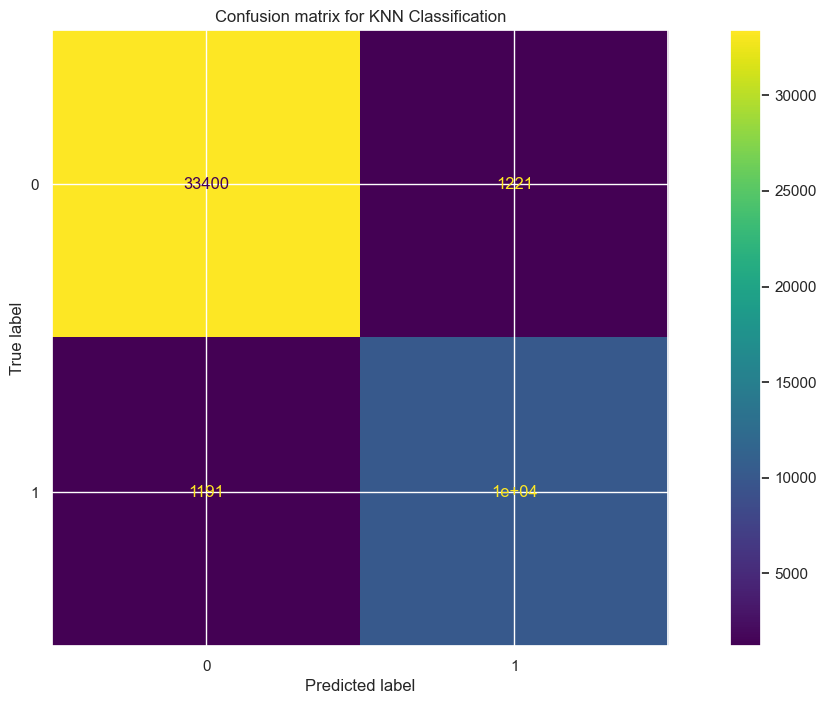

In [22]:
classification_knn(balance_type="ros", grid=True)

Accuracy: 0.862802163195274
F1 Score:  0.7634702512449919

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     34621
           1       0.67      0.89      0.76     11422

    accuracy                           0.86     46043
   macro avg       0.81      0.87      0.83     46043
weighted avg       0.89      0.86      0.87     46043



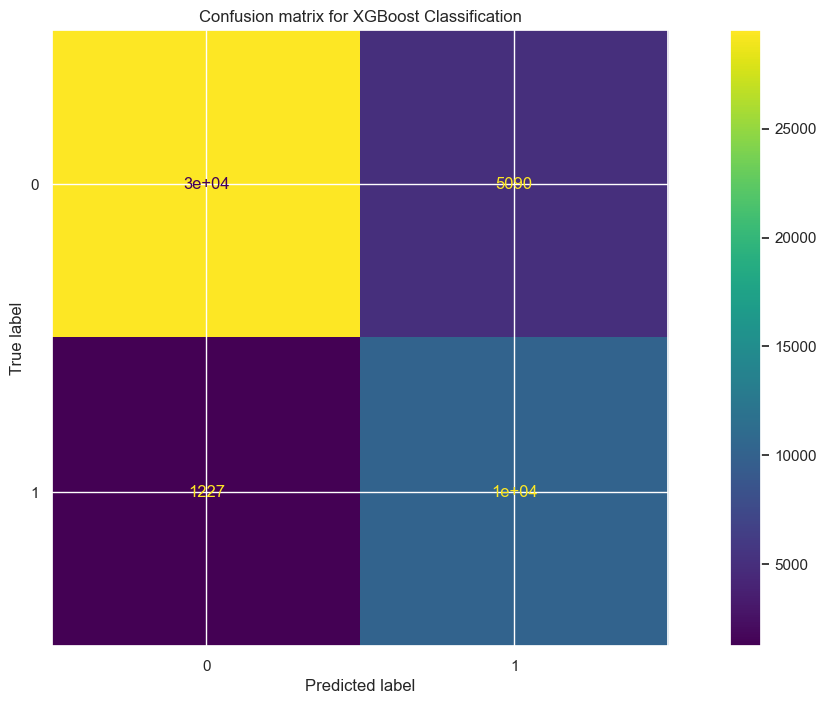

In [22]:
classification_xgb(balance_type="ros", grid=False)

Accuracy:  0.5758530069717438
F1 Score:  0.404476565120605

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.57      0.67     34621
           1       0.31      0.58      0.40     11422

    accuracy                           0.58     46043
   macro avg       0.56      0.58      0.54     46043
weighted avg       0.68      0.58      0.60     46043



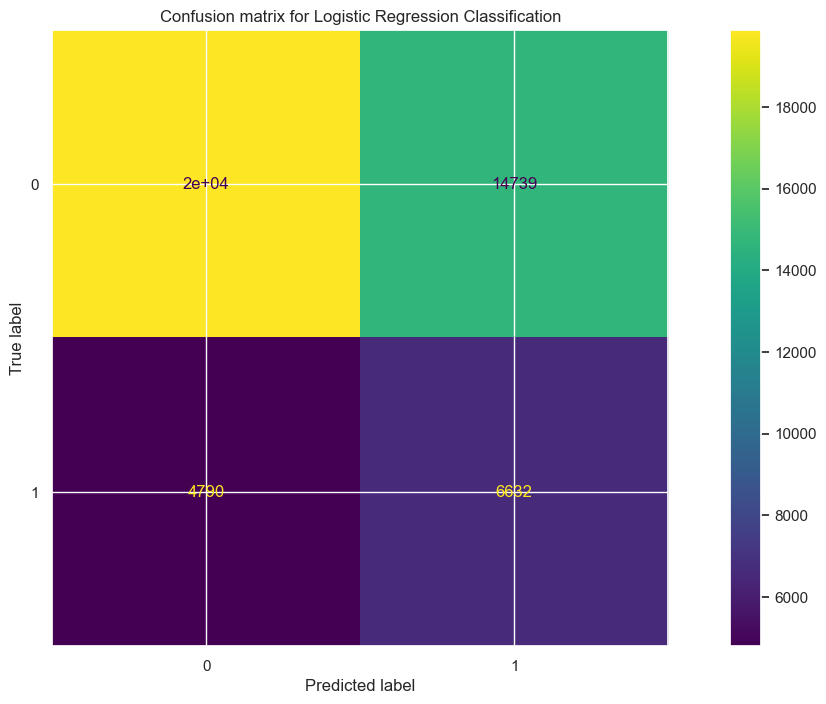

In [26]:
classification_lr(balance_type="ros")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               8704      
                                                                 
 dense_19 (Dense)            (None, 67)                8643      
                                                                 
 dense_20 (Dense)            (None, 1)                 68        
                                                                 
Total params: 17415 (68.03 KB)
Trainable params: 17415 (68.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
626/626 [==============================] - 1s 2ms/step - loss: 375.4306 - recall_3: 0.3272 - val_loss: 100.2924 - val_recall_3: 0.9198
Epoch 2/100
626/626 [==============================] - 1s 1ms/step - loss: 189.0988 - recall_3: 0.3381 - val_loss: 60.4181 - val_recall

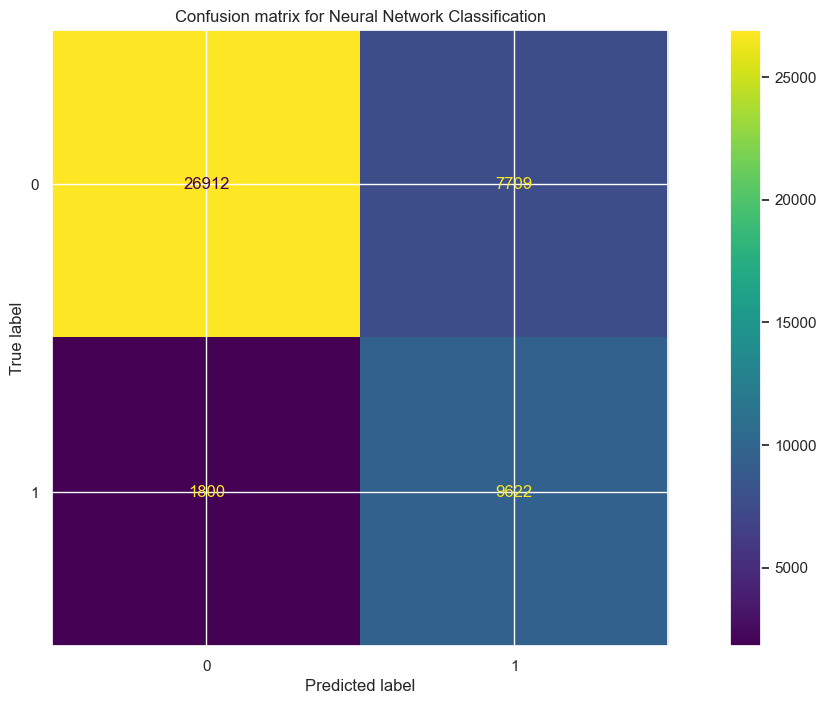

In [16]:
classification_rnn()